In [1]:
%load_ext autoreload
%autoreload 1
import os

from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import Client
import pandas as pd

from insight.catalog import InsightCatalog
from insight.rotate import rotate_zne
from insight.util import EventDownloader, TraceFile

# Parameters

In [2]:
DATA_DIR = "../data/"
DATALESS_SEED = "ELYSE.dataless"
CATALOG_BASE_URL = "https://www.seis-insight.eu/static/mqs-catalogs/v14/"
CATALOG_STD = "events_extended_multiorigin_v14_2023-01-01.xml"
CATALOG_EXT = "events_mars_extended_multiorigin_v14_2023-01-01.xml"

# https://www.iris.edu/hq/sis/insight
network = "XB"
station = "ELYSE"
location = "02"
min_ang, max_ang = 30, 90
before, after = 30, 300
inv_time = UTCDateTime(2020, 1, 1)  # Only used to get channel metadata
channels = ["BHU", "BHV", "BHW"]

## Fetch Inventory
Get lat/lon and sensor orientations from Iris

In [3]:
client = Client("IRIS")
insight = client.get_stations(network=network, station=station, location=location, channel="BH?", level="channel")[0]
lat, lon = insight[0].latitude, insight[0].longitude
bh_orientations = {
    ch: insight.get_orientation(f"{network}.{station}.{location}.{ch}", inv_time)
    for ch in channels
}

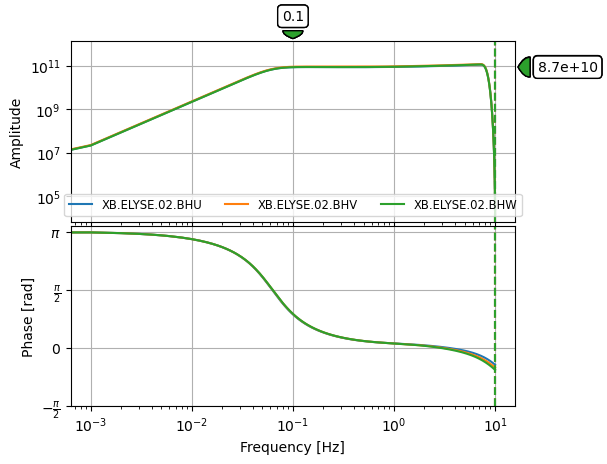

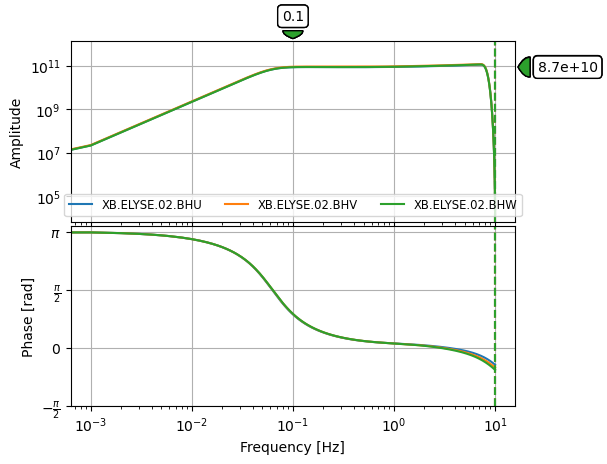

In [4]:
inv = read_inventory("../inventory_VBB.xml")
inv.plot_response(0.001, station=station, location=location, channel="BH?", time=inv_time, show=False)

## Build Catalog
And filter for A

In [5]:
cb = InsightCatalog(CATALOG_BASE_URL + CATALOG_EXT, DATA_DIR)
catalog = cb.parse()
catalog.picks.loc["S1222a"]

,id,phase,arrival,channel,agency_id,author
earthquake name,,,,,,
S1222a,mqs2022isne,Peak_M2.4,2022-05-04 23:32:19.057758+00:00,BHZ,mqs,jc
S1222a,mqs2022isne,S_spectral_end,2022-05-04 23:37:01.378327+00:00,BHZ,mqs,jc
S1222a,mqs2022isne,S_spectral_start,2022-05-04 23:31:21.942364+00:00,BHZ,mqs,jc
S1222a,mqs2022isne,S,2022-05-04 23:31:17.900000+00:00,BH?,NaN,Ceylan and Giardini alignment
S1222a,mqs2022isne,P,2022-05-04 23:27:34+00:00,BH?,NaN,Ceylan and Giardini alignment
S1222a,mqs2022isne,Peak_MbS,2022-05-04 23:31:40.885650+00:00,BHR,mqs,sc
S1222a,mqs2022isne,Peak_MbP,2022-05-04 23:28:00.697014+00:00,BHZ,mqs,sc
S1222a,mqs2022isne,y2,2022-05-04 23:31:30.853700+00:00,BHZ,mqs,sc
S1222a,mqs2022isne,S,2022-05-04 23:31:20.152806+00:00,BHT,mqs,sc


In [6]:
events = catalog.events
events_a = events[events["quality"] == "A"]

def first_p_phase(event: pd.Series) -> dict:
    event_picks = catalog.picks.loc[event.name]
    p = event_picks[(event_picks["phase"] == "P") & (event_picks["agency_id"] == "mqs")]
    pp = event_picks[(event_picks["phase"] == "PP") & (event_picks["agency_id"] == "mqs")]
    if len(p) > 0:
        return {"arrival": p.iloc[0].arrival, "phase": "P"}
    if len(pp) > 0:
        return {"arrival": pp.iloc[0].arrival, "phase": "PP"}
    raise ValueError(f"No P/PP phase found for {event.index}")

events_a = pd.concat((events_a, events_a.apply(first_p_phase, axis="columns", result_type="expand")), axis="columns")
events_a

,id,region name,time,quality,mqs_azimuth,mqs_distance,M_w,arrival,phase
earthquake name,,,,,,,,,
S1222a,mqs2022isne,Aeolis Northeast,2022-05-04T23:23:07.710516Z,A,109.000000,37.014014,4.6,2022-05-04 23:27:45.690496+00:00,P
S1133c,mqs2022cixp,Elysium Southeast,2022-02-03T08:04:36.469259Z,A,90.000000,30.006507,3.8,2022-02-03 08:08:25.717507+00:00,P
S1102a,mqs2022aceh,Syrtis Major Northwest,2022-01-02T04:27:10.093677Z,A,295.000000,73.309309,3.2,2022-01-02 04:35:30.847431+00:00,P
S1094b,mqs2021zdzn,Diacria Southwest,2021-12-24T22:38:02.749173Z,A,40.000000,59.653654,4.0,2021-12-24 22:45:09.075499+00:00,P
S1048d,mqs2021vwbn,Elysium Southeast,2021-11-07T22:00:15.254098Z,A,100.000000,30.186186,3.6,2021-11-07 22:04:05.355199+00:00,P
S1022a,mqs2021tyvj,Elysium Northeast,2021-10-11T23:14:29.105382Z,A,63.000000,30.725225,3.6,2021-10-11 23:18:25.025302+00:00,P
S1015f,mqs2021tkqn,Elysium Southeast,2021-10-04T04:52:29.248537Z,A,93.000000,27.490991,2.9,2021-10-04 04:56:00.605894+00:00,P
S1000a,mqs2021sijy,Lunae Palus Northwest,2021-09-18T17:46:20.639751Z,A,55.000000,128.291291,4.1,2021-09-18 18:01:47.477589+00:00,PP
S0976a,mqs2021qpls,Coprates Northwest,2021-08-25T03:32:20.629953Z,A,101.000000,146.259259,4.3,2021-08-25 03:49:06.404728+00:00,PP


## Fetch 'A' Quality Events

In [7]:
st_uvw = {}

events_dl = EventDownloader(DATA_DIR, before=before, after=after)

for evt in events_a.index:
    e = events_a.loc[evt]
    st_uvw[evt] = events_dl.get_stream(
        network=network,
        station=station,
        location=location,
        channel="BH?",
        est_p_arrival=e.arrival,
        evt_id=e.id
    )

## Rotate to ZNE

In [14]:
st_zne = {}

for evt in events_a.index:
    try:
        # Fix dodgy trace lengths with a trim
        st_uvw[evt].trim(
            starttime=max([t.meta.starttime for t in st_uvw[evt]]),
            endtime=min([t.meta.endtime for t in st_uvw[evt]]),
        )
        st_zne[evt] = rotate_zne(st_uvw[evt], bh_orientations)
    except ValueError as e:
        print(st_uvw[evt])
        raise e

## Save rotated streams and catalog to disk

Sort by M_w

In [15]:
events_a.sort_values("M_w", ascending=False).to_parquet(os.path.join(DATA_DIR, "a_quality.parquet"), index=True)
zne_dst_dir = os.path.join(DATA_DIR, "zne")
if not os.path.exists(zne_dst_dir):
    os.mkdir(zne_dst_dir)

for evt in events_a.index:
    trace_file = TraceFile(network, station, location, events_a.loc[evt].id, format="MSEED")
    st_zne[evt].write(os.path.join(zne_dst_dir, str(trace_file)), format="MSEED")

/opt/homebrew/Caskroom/miniconda/base/envs/insight-notebooks/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
